# Range propagation
[![View On GitHub](https://img.shields.io/badge/View_in_Github-grey?logo=github)](https://github.com/Qrlew/docs/blob/main/tutorials/range_propagation.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Qrlew/pyqrlew/blob/main/examples/range_propagation.ipynb)

When one wants to release aggregate statistics with the guarantee that the output will not reveal anything about the individuals in the data, [differential privacy](https://en.wikipedia.org/wiki/Differential_privacy) is the way to go.
Many [differentialy private mechanisms](https://en.wikipedia.org/wiki/Differential_privacy) consist of sums where each term is known to be bounded — so that the *sensitivity* is easy to compute — to which some noise is added, usually [Laplace](https://en.wikipedia.org/wiki/Additive_noise_differential_privacy_mechanisms#Laplace_Mechanism) or [Gaussian](https://en.wikipedia.org/wiki/Additive_noise_differential_privacy_mechanisms#Gaussian_Mechanism).
For these mechanisms and others, it is crucial to be able to bound some values.

*Bounding* can be achieved in many ways.

- Bounds can be *forced* by clipping values, but then the computation of the statistics may be biased.
- Bounds can be *inferred* by ranges propagation, a range of the values is propagated across successive transforms.

A case where the tradeoff between *clipping* and *propagating ranges* is particularly difficult is the case of values with few remote outliers.
If ranges are simply propagated, the presence of outliers forces the sensitivities to be large and therefore the noise added reduces drastically the utility of the result.
To avoid adding too much noise, the values can be clipped so that the noise added is smaller, but then the outliers are dropped and the statistics are biased.

In this notebook, we'll focus on *range propagation* using [`qrlew`](https://qrlew.github.io/).

In [1]:
%%capture
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install graphviz
!pip install graphviz
!pip install pyqrlew

In [2]:
import logging
logging.disable(logging.INFO)

We load a csv extract of the [Kuzak Dempsy's dataset](https://data.world/kudem):

In [3]:
import pyqrlew as pq
qdb = pq.from_csv(
    table_name="heart_data",
    csv_file="https://storage.googleapis.com/qrlew-demo-data/heart_data.csv"
)

In [4]:
import pandas as pd
pd.DataFrame(qdb.execute("SELECT * FROM heart_data")).head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Qrlew transforms each SQL notion into a `Relation`, which is an intermediate representation that is well-suited for multiple query rewriting purposes.

The `heart_data` table is turned into:

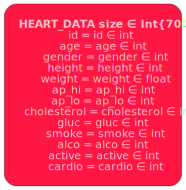

In [5]:
import graphviz

ds = qdb.dataset()
display(graphviz.Source(ds.relations()[0][1].dot()))


The `Relation` object holds information about columns and their associated Qrlew [data types](https://github.com/Qrlew/qrlew/blob/b4960d57b7ac047b525c36b9cb9eb3395e0f4029/src/data_type/mod.rs#L2207) (including bounds).

These Qrlew data types are transformed from the database's original types.
Therefore, when importing data from sources like CSV files or pandas DataFrames that lack support for certain types (such as bytes or lists),
you may sacrifice the detailed distinctions that Qrlew offers.

## Bound the columns of a table

We adopt the perspective of the data owner, who aims to safeguard user privacy. We focus on a subset of the heart_data containing four columns:

- `id` (integer):  contains unique identifiers, which must remain confidential,
- `gender` (integer): 1 (Male) or 2 (Female),
- `height` (integer),
- `weight` (integer).

We need to bounds the `height` and `weight` columns.
We can limit the height to a range of 140 to 200 and the weight to a range of 40 to 130 kg.


The data preparation involves creating a new dataset with specific column transformations:
- `id` (integer): remains unchanged
- `gender` (string): exclude values other than 1 or 2 then replace 0 with 'M', 1 with 'F',
- `height` (float): exclude values outside the range [140.0, 200.0],
- `weight` (float): exclude values outside the range [40.0, 130.0].

This preparation can be transcripted as an SQL query:

In [6]:
query = """
WITH
    bounds_table AS (SELECT
        id,
        height,
        weight,
        CASE WHEN id = 1 THEN 'M' ELSE 'F' END AS gender
    FROM heart_data
    WHERE
        height > 140. AND height < 200. AND
        weight > 40. AND weight < 130. AND
        gender IN (1, 2)
    )
SELECT * FROM bounds_table
"""

We define a new `Relation` that mirrors the dataset's SQL query operation:

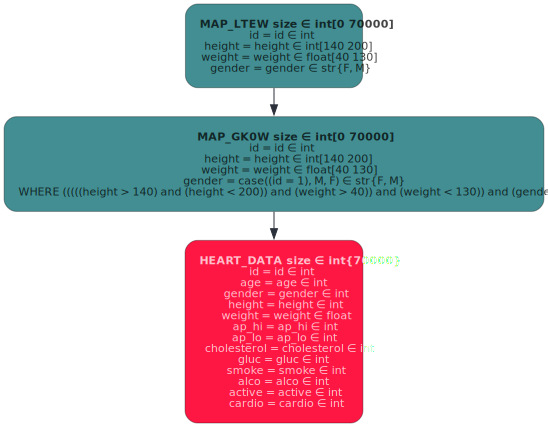

In [7]:
relation = ds.sql(query)
display(graphviz.Source(relation.dot()))

At the basis in red, we find the original table `heart_data` with all its columns.

The first mapping operation involves selecting the `id`, `gender`, `height` and `weight` columns and coercing their types.

The output `Relation` contains the four columns with their datatypes propagated:

- The `gender` column has `str` type with only two possible values `M` and `F`.
- The `height` and `weigh` columns contain bounded floats.

In [8]:
print(f"The propagated datatype is: {relation.schema()}")

The propagated datatype is: {id: int, height: int[140 200], weight: float[40 130], gender: str{F, M}}


Importantly, these data types have been extended **independently, without necessitating any interaction with the database**.

At this stage, the computation of aggregation sensitivity becomes feasible, but exclusively when such aggregation is executed on one of the initial columns.


## Range propagation

When confronted with the aggregation of composite columns, one approach to gauge sensitivity involves employing the automatic bounds determination algorithm introduced by [Wilson et al. (2019)](https://arxiv.org/abs/1909.01917).

However, a drawback of this method is that it consumes some of the privacy budget allocated for the aggregation.

In the next section, we'll delve into how Qrlew extends the boundaries of the initial columns to composite columns without spending any privacy budget.

As a first example, we reuse the previous query and compute the BMI (Body Mass Index) using the formula:
$$BMI = \frac{weight(kg)}{height(m)^2}$$

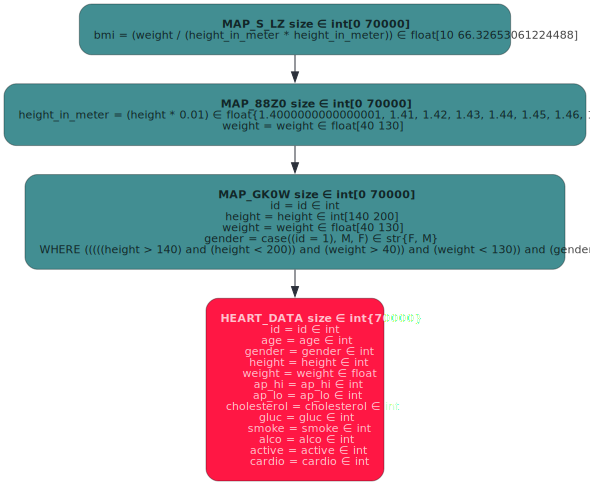

In [9]:
query = """
WITH
    bounds_table AS (
        SELECT
            id,
            height,
            weight,
            CASE WHEN id = 1 THEN 'M' ELSE 'F' END AS gender
        FROM heart_data
        WHERE
            height > 140 AND height < 200 AND
            weight > 40.00 AND weight < 130. AND
            gender IN (1, 2)
    ),
    convert_table AS (
        SELECT
            height * 0.01 AS height_in_meter,
            weight
        FROM bounds_table
    )
SELECT weight / (height_in_meter * height_in_meter) AS bmi FROM convert_table
"""
relation = ds.sql(query)
display(graphviz.Source(relation.dot()))

The two lower relations are the ones we previously had, which are fed into a new `Relation` that performs the conversion of the `height` column from centimeters to meters.

The updated ranges are automatically calculated as `[140, 200] -> [1.4, 2.0]`.

The BMI computation takes place in the uppermost `Relation`, the corresponding ranges are:
$$
\left [ \frac{\min (weight(kg))}{\max (height(m)^2)}, \frac{\max (weight(kg))}{\min (height(m)^2)} \right]
$$

In [10]:
relation.schema()

'{bmi: float[10 66.32653061224488]}'

This can be converted to the true min and max:

In [11]:
df = pd.DataFrame(qdb.eval(relation))
print(f"bmi: [{df['bmi'].min()}, {df['bmi'].max()}]")


bmi: [14.527376033057852, 63.975401706010715]


We observe that the estimated bounds encompass the actual bounds. This implies that we might be introducing an excessive amount of noise. If we aim to incorporate less noise, we can tighten the bounds; however, this adjustment could potentially introduce bias into the final outcome.

Let now consider another example. We want to compute the [Lorentz formula](https://link.springer.com/chapter/10.1007/978-3-211-89836-9_803) given by:

$$
\left\{
    \begin{array}{ll}
        0.75 * height - 62.5 & \text{if  gender='M'} \\
        0.60 * height -40.0 & \text{if  gender='F'} \\
    \end{array}
\right.
$$

**To illustrate the process of joining**, we calculate the Lorentz formula separately for males and females using two distinct common table expressions.
Subsequently, we merge these tables through a join operation and retrieve the appropriate formula based on the individual's gender.

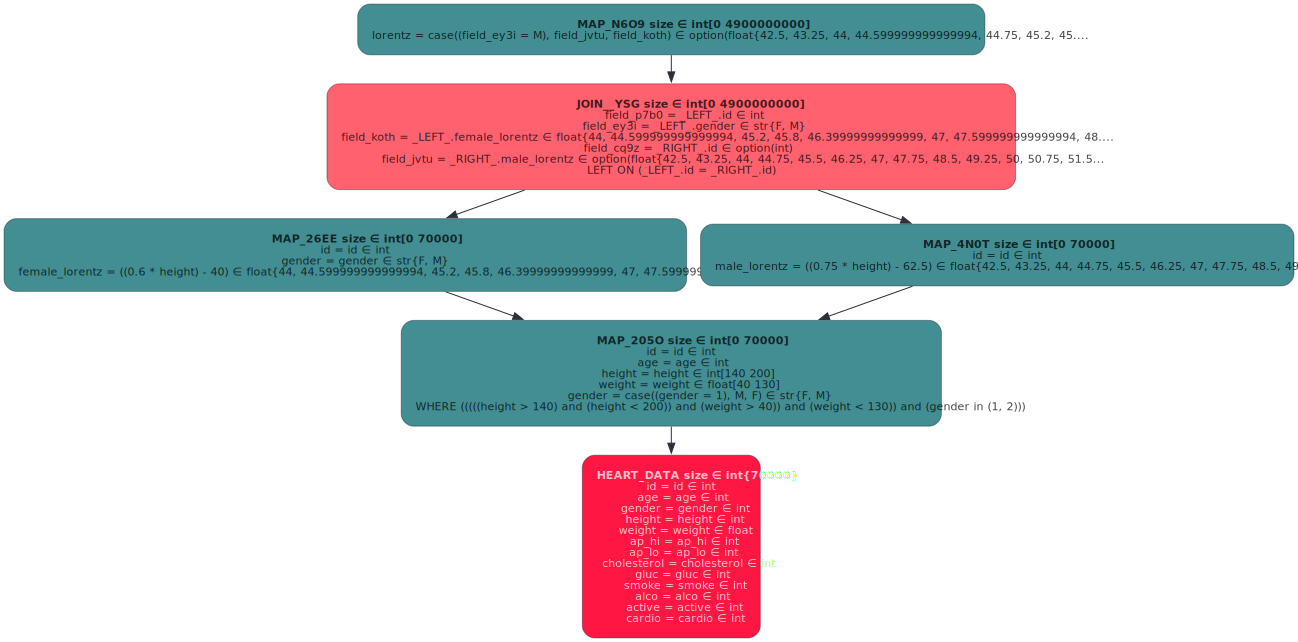

In [12]:
query = """
WITH
    bounds_table AS (
        SELECT
            id,
            age,
            height,
            weight,
            CASE WHEN gender = 1 THEN 'M' ELSE 'F' END AS gender
        FROM heart_data
        WHERE
            height > 140 AND height < 200 AND
            weight > 40.00 AND weight < 130. AND
            gender IN (1, 2)
    ),
    female_table AS (
        SELECT
            id,
            gender,
            0.6 * height -40.0 AS female_lorentz
        FROM bounds_table
    ),
    male_table AS (
        SELECT
            id,
            0.75 * height - 62.5 AS male_lorentz
        FROM bounds_table
    )
SELECT CASE WHEN gender = 'M' THEN male_lorentz else female_lorentz END AS lorentz FROM female_table LEFT JOIN male_table ON female_table.id = male_table.id
"""
relation = ds.sql(query)

display(graphviz.Source(relation.dot()))

Once more, in this example, you can trace follow the propagation of the ranges as they propagate throughout all the relations.

Finally, the propagated ranges for the Lorentz formula are:

In [13]:
relation.schema()

'{lorentz: option(float{42.5, 43.25, 44, 44.599999999999994, 44.75, 45.2, 45.5, 45.8, 46.25, 46.39999999999999, 47, 47.599999999999994, 47.75, 48.2, 48.5, 48.8, 49.25, 49.39999999999999, 50, 50.599999999999994, 50.75, 51.2, 51.5, 51.8, 52.25, 52.39999999999999, 53, 53.599999999999994, 53.75, 54.2, 54.5, 54.8, 55.25, 55.39999999999999, 56, 56.599999999999994, 56.75, 57.2, 57.5, 57.8, 58.25, 58.39999999999999, 59, 59.599999999999994, 59.75, 60.2, 60.5, 60.8, 61.25, 61.39999999999999, 62, 62.599999999999994, 62.75, 63.2, 63.5, 63.8, 64.25, 64.39999999999999, 65, 65.6, 65.75, 66.2, 66.5, 66.8, 67.25, 67.39999999999999, 68, 68.6, 68.75, 69.2, 69.5, 69.8, 70.25, 70.39999999999999, 71, 71.6, 71.75, 72.2, 72.5, 72.8, 73.25, 73.39999999999999, 74, 74.6, 74.75, 75.19999999999999, 75.5, 75.8, 76.25, 76.39999999999999, 77, 77.6, 77.75, 78.19999999999999, 78.5, 78.8, 79.25, 79.39999999999999, 80, 80.75, 81.5, 82.25, 83, 83.75, 84.5, 85.25, 86, 86.75, 87.5})}'

The exact ranges are:

In [14]:
df = pd.DataFrame(qdb.eval(relation))
print(f"lorentz: [{df['lorentz'].min()}, {df['lorentz'].max()}]")


lorentz: [43.25, 86.0]


In certain scenarios, when there's a high correlation between columns, it might not be advisable to use propagated ranges.
This is because the accurate range could be influenced by significant correlations that are not evident from external data.
In such instances, it could be beneficial to allocate budget towards computing ranges using the automatic boundary determination algorithm ([Wilson et al. 2019](https://arxiv.org/abs/1909.01917)).

However, how can an analyst without free database access determine whether he should allocate budget to compute the ranges?

This is where utilizing Sarus becomes advantageous.

By employing [Sarus](https://www.sarus.tech/), the analyst gains **access to a synthetic dataset** wherein inter-column correlations are replicated.

This empowers the analyst to **devise a strategy without expending privacy resources**, as they can scrutinize the synthetic dataset for insights and make informed decisions.